# Air Quality Prediction

[World's Air Pollution: Real-Time Air Quality Index](https://waqi.info/)

https://aqicn.org/json-api/doc/

## Prepare environment

In [1]:
import pandas as pd
import numpy as np
import holidays
from meteostat import Point, Daily
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

np.random.seed(42)
random.seed(42)

## Configuration

In [2]:
# Let's first keep X window and y window same size
historical_window_size = 3
prediction_window_size = 3

## Prepare data

### Load data

In [3]:
aqi_pd = pd.read_csv("../data/air_quality_history.csv", skipinitialspace=True)

In [4]:
# Make sure column names are stripped
aqi_pd.columns

Index(['date', 'pm25', 'pm10', 'no2', 'so2', 'co'], dtype='object')

In [5]:
aqi_pd["date"] = pd.to_datetime(aqi_pd["date"], format="%Y/%m/%d")

In [6]:
aqi_pd = aqi_pd.set_index("date")

In [7]:
aqi_pd.head()

,pm25,pm10,no2,so2,co
date,,,,,
2025-07-01,28.0,12.0,3.0,1.0,5.0
2025-07-02,41.0,22.0,7.0,1.0,5.0
2025-07-03,65.0,16.0,3.0,NaN,5.0
2025-07-04,42.0,12.0,3.0,1.0,5.0
2025-07-05,41.0,14.0,2.0,1.0,5.0


In [8]:
aqi_pd.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,pm25,pm10,no2,so2,co
count,1300.000000,1301.000000,1292.000000,1205.000000,1294.000000
mean,44.866923,15.099923,5.592105,3.140249,3.980680
std,18.238856,7.775752,3.761483,1.698959,1.555003
min,10.000000,2.000000,1.000000,1.000000,1.000000
25%,31.000000,10.000000,3.000000,2.000000,3.000000
50%,43.500000,14.000000,5.000000,3.000000,4.000000
75%,56.000000,19.000000,7.000000,4.000000,5.000000
90%,68.000000,25.000000,11.000000,5.000000,6.000000
95%,76.000000,29.000000,13.000000,6.000000,7.000000
max,117.000000,90.000000,27.000000,15.000000,12.000000


### Handle missing dates

In [9]:
full_range = pd.date_range(start=aqi_pd.index.min(), end=aqi_pd.index.max(), freq="D")

# Check for missing dates
full_range.difference(aqi_pd.index)

DatetimeIndex(['2024-12-30'], dtype='datetime64[ns]', freq='D')

In [10]:
aqi_pd.loc[pd.Timestamp("2024-12-30")] = aqi_pd.loc[pd.Timestamp("2024-12-31")]
aqi_pd = aqi_pd.sort_index()

In [11]:
full_range.difference(aqi_pd.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

### Handle N/A values

In [12]:
aqi_pd.isna().sum()

pm25     3
pm10     1
no2     10
so2     97
co       8
dtype: int64

In [13]:
aqi_pd = aqi_pd.fillna(aqi_pd.median())

In [14]:
aqi_pd.isna().sum()

pm25    0
pm10    0
no2     0
so2     0
co      0
dtype: int64

## Feature engineering

### Calendar Features

In [15]:
svk_holidays = holidays.Slovakia()

datetime_pd = aqi_pd.index

aqi_pd["year"] = datetime_pd.year
aqi_pd["month"] = datetime_pd.month
aqi_pd["day_of_month"] = datetime_pd.day
aqi_pd["day_of_week"] = datetime_pd.dayofweek
aqi_pd["day_of_year"] = datetime_pd.dayofyear
aqi_pd["week_of_year"] = datetime_pd.isocalendar().week
aqi_pd["is_leap_year"] = datetime_pd.is_leap_year.astype(int)
aqi_pd["is_working_day"] = [int(svk_holidays.is_working_day(x)) for x in datetime_pd]
aqi_pd["is_feb29"] = ((aqi_pd["month"] == 2) & (aqi_pd["day_of_month"] == 29)).astype(int)

### Cyclical features

TODO: 
For cyclical features (month, day_of_week, hour, day_of_year), it's often better to transform them
into sine and cosine components to preserve the cyclical nature and avoid arbitrary ordinal relationships.

### Meteorological data

[Meteorological Parameters](https://dev.meteostat.net/formats.html#meteorological-parameters)

In [16]:
# Define Poprad coordinates
# Coordinates of Poprad-Tatry Airport (LZTT) meteo station.
location = Point(49.07, 20.24, 718)  # Lat, Lon, Elevation (optional but good)

start_date = datetime_pd.min()
end_date = datetime_pd.max()

daily_weather = Daily(location, start_date, end_date)
weather_pd = daily_weather.fetch()

print(weather_pd.head())

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2021-12-27 -13.1 -17.2  -8.0  <NA>  <NA>  <NA>   2.7  13.0  1009.1  <NA>
2021-12-28  -9.3 -13.8  -2.0  <NA>  <NA>  <NA>   4.0  13.0  1006.6  <NA>
2021-12-29  -4.1  -8.1  -0.9  <NA>  <NA>  <NA>   4.8  14.8  1005.6  <NA>
2021-12-30  -3.6  -9.6   1.8  <NA>  <NA>  <NA>   4.7  13.0  1015.0  <NA>
2021-12-31   3.9  -0.2   8.2  <NA>  <NA>  <NA>  15.2  33.3  1017.1  <NA>


In [17]:
weather_pd.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,1303.0,1303.0,1303.0,1168.0,4.0,0.0,1303.0,1292.0,1303.0,0.0
mean,7.873062,2.58749,13.147276,2.109332,2.0,<NA>,12.478511,26.593111,1016.221182,<NA>
std,7.986217,7.360569,9.126794,4.386507,1.414214,<NA>,6.629821,9.283313,7.993424,<NA>
min,-13.1,-20.2,-8.0,0.0,1.0,<NA>,2.6,11.1,987.5,<NA>
25%,1.2,-3.0,6.0,0.0,1.0,<NA>,7.8,20.4,1011.6,<NA>
50%,7.7,2.9,13.1,0.1,1.5,<NA>,10.5,24.1,1016.8,<NA>
75%,14.65,8.6,20.85,2.1,2.5,<NA>,15.3,31.5,1021.2,<NA>
max,24.5,18.4,34.0,42.7,4.0,<NA>,47.8,57.4,1039.8,<NA>


In [18]:
# No data available for these features from selected meteo station
weather_pd.drop(["wdir", "tsun"], axis=1, inplace=True)

In [19]:
weather_pd.isna().sum()

tavg       0
tmin       0
tmax       0
prcp     135
snow    1299
wspd       0
wpgt      11
pres       0
dtype: int64

In [20]:
# N/A here means that there was no rain or snow - so filling with 0 instead
weather_pd["prcp"] = weather_pd["prcp"].fillna(0.0)
weather_pd["snow"] = weather_pd["snow"].fillna(0.0)

# Let's assume that rest N/A is just missing reading, and fill with median
weather_pd.fillna(weather_pd.median(), inplace=True)

In [21]:
weather_pd.isna().sum()

tavg    0
tmin    0
tmax    0
prcp    0
snow    0
wspd    0
wpgt    0
pres    0
dtype: int64

In [22]:
merged_df = pd.merge_asof(aqi_pd, weather_pd, left_index=True, right_index=True)

In [23]:
merged_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,43.5,37.0,25.0,2.0,12.0,2021,12,27,0,361,...,1,0,-13.1,-17.2,-8.0,0.0,0.0,2.7,13.0,1009.1
2021-12-28,105.0,36.0,21.0,3.0,9.0,2021,12,28,1,362,...,1,0,-9.3,-13.8,-2.0,0.0,0.0,4.0,13.0,1006.6
2021-12-29,104.0,26.0,17.0,1.0,10.0,2021,12,29,2,363,...,1,0,-4.1,-8.1,-0.9,0.0,0.0,4.8,14.8,1005.6
2021-12-30,73.0,17.0,8.0,1.0,9.0,2021,12,30,3,364,...,1,0,-3.6,-9.6,1.8,0.0,0.0,4.7,13.0,1015.0
2021-12-31,56.0,6.0,5.0,1.0,12.0,2021,12,31,4,365,...,1,0,3.9,-0.2,8.2,0.0,0.0,15.2,33.3,1017.1


In [24]:
merged_df.columns

Index(['pm25', 'pm10', 'no2', 'so2', 'co', 'year', 'month', 'day_of_month',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_leap_year',
       'is_working_day', 'is_feb29', 'tavg', 'tmin', 'tmax', 'prcp', 'snow',
       'wspd', 'wpgt', 'pres'],
      dtype='object')

### Convert all features to float

Converting all features to floats is a fundamental preprocessing step for neural networks. It ensures compatibility with the underlying mathematical operations, facilitates normalization, and aligns with the requirements of deep learning frameworks.

In [ ]:
merged_df = merged_df.astype(float)

In [26]:
merged_df.dtypes

pm25              float64
pm10              float64
no2               float64
so2               float64
co                float64
year                int32
month               int32
day_of_month        int32
day_of_week         int32
day_of_year         int32
week_of_year       UInt32
is_leap_year        int64
is_working_day      int64
is_feb29            int64
tavg              Float64
tmin              Float64
tmax              Float64
prcp              Float64
snow              Float64
wspd              Float64
wpgt              Float64
pres              Float64
dtype: object

## Explore trends

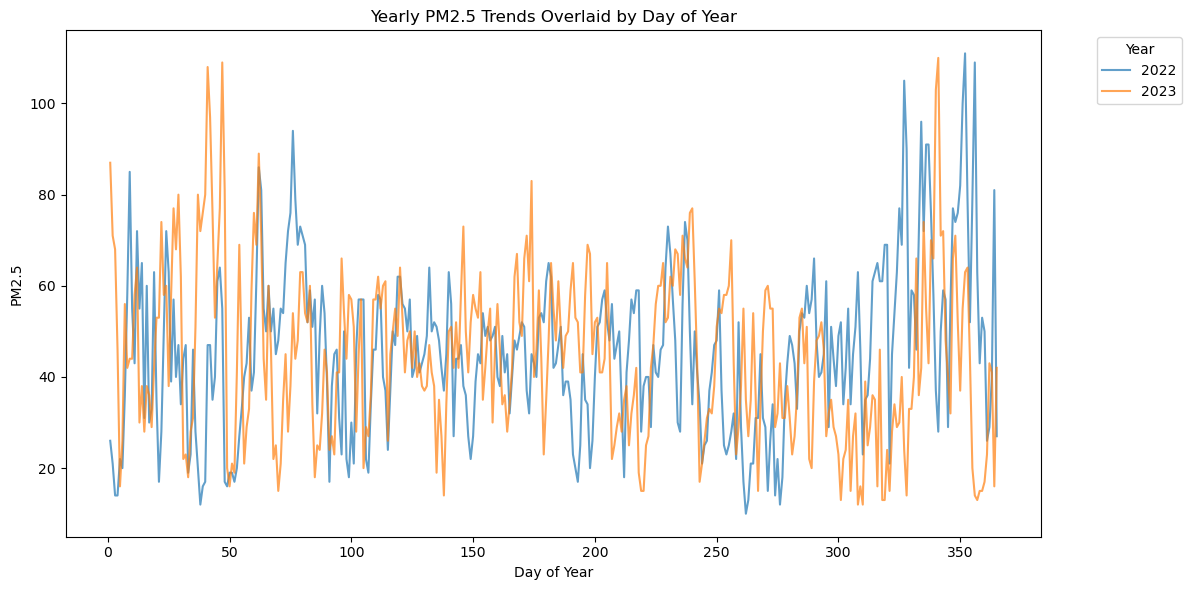

In [27]:
plt.figure(figsize=(12, 6))
for year, group in aqi_pd.groupby("year"):
    if (year in [2022, 2023]):
        plt.plot(group["day_of_year"], group["pm25"], label=str(year), alpha=0.7)

plt.xlabel("Day of Year")
plt.ylabel("PM2.5")
plt.title("Yearly PM2.5 Trends Overlaid by Day of Year")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

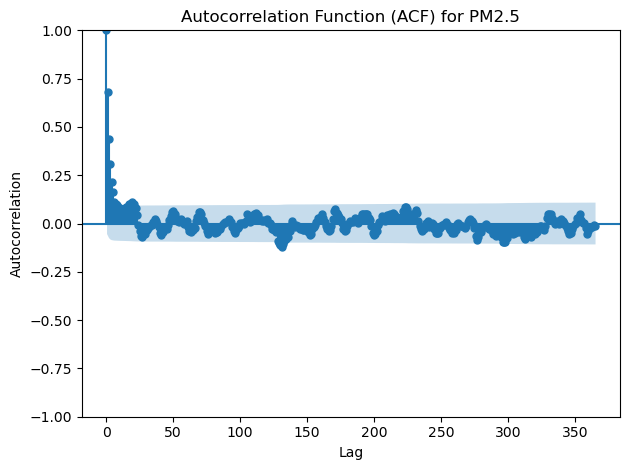

In [28]:
plt.figure(figsize=(10, 5))
plot_acf(aqi_pd["pm25"], lags=365)
plt.title("Autocorrelation Function (ACF) for PM2.5")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

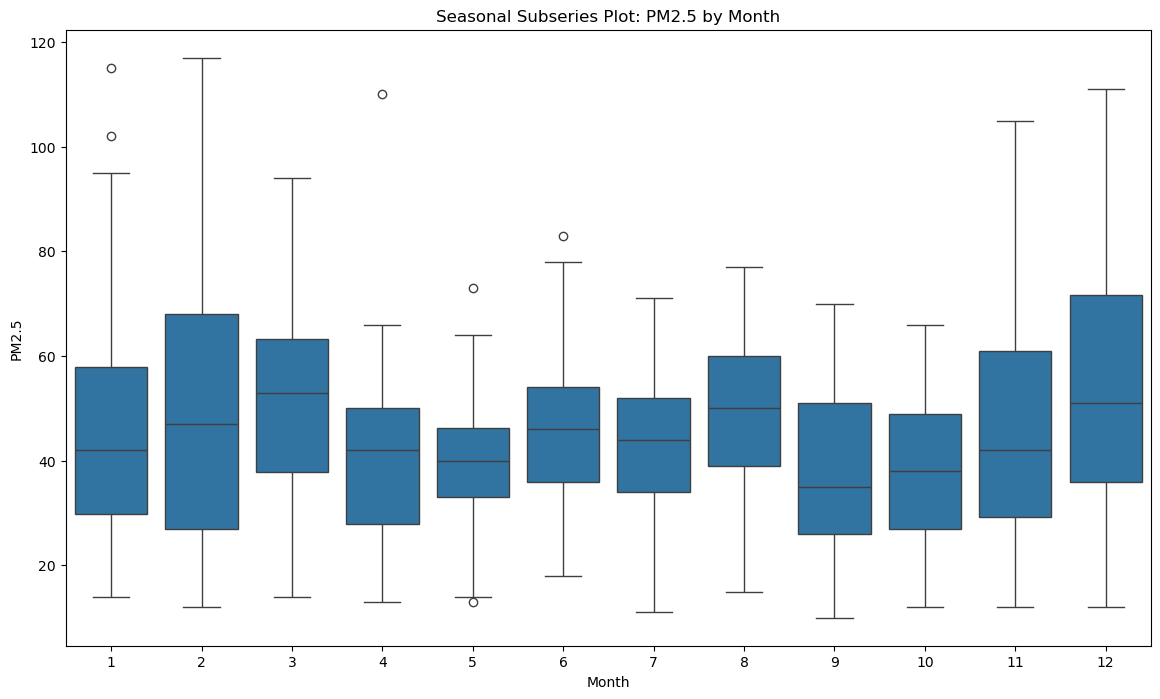

In [29]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="month", y="pm25", data=aqi_pd)
plt.title("Seasonal Subseries Plot: PM2.5 by Month")
plt.xlabel("Month")
plt.ylabel("PM2.5")
plt.show()

<Figure size 1400x1000 with 0 Axes>

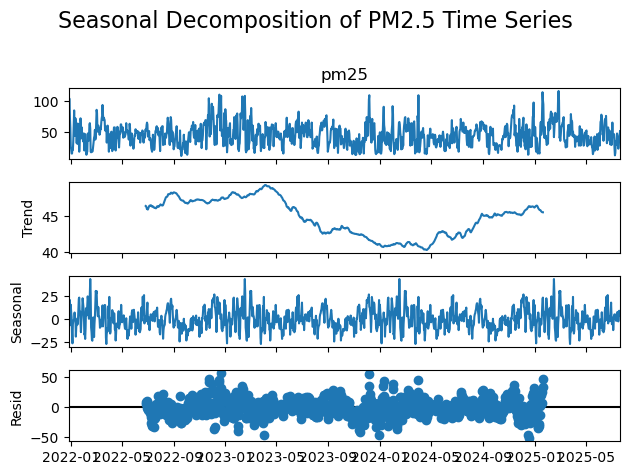

In [30]:
# Ensure pm25 is float and has no missing values for decomposition
pm25_series = aqi_pd["pm25"].astype(float).interpolate()

result = seasonal_decompose(pm25_series, model='additive', period=365)

plt.figure(figsize=(14, 10))
result.plot()
plt.suptitle("Seasonal Decomposition of PM2.5 Time Series", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

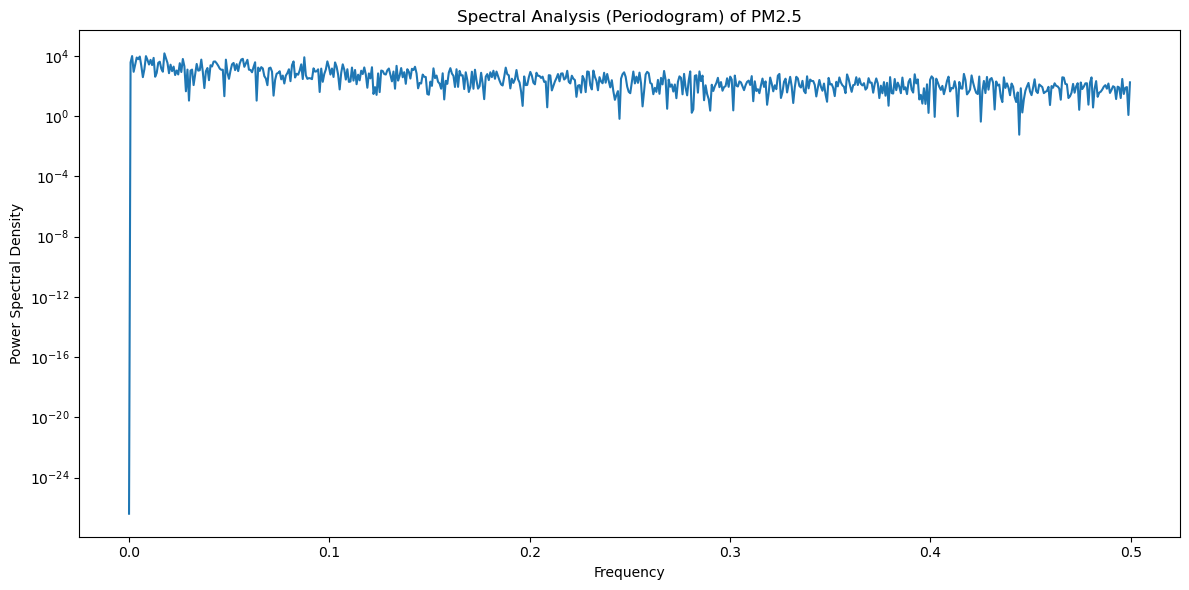

In [31]:
# Fill missing values in pm25 for spectral analysis
pm25_filled = aqi_pd["pm25"].astype(float).values

# Compute the periodogram
freqs, power = periodogram(pm25_filled)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs, power)
plt.title("Spectral Analysis (Periodogram) of PM2.5")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.tight_layout()
plt.show()

## Split Data into Training, Validation, and Test Sets

In [32]:
train_size = int(len(merged_df) * 0.8)
val_size = int(len(merged_df) * 0.1)

train_df = merged_df.iloc[:train_size]
val_df = merged_df.iloc[train_size : train_size + val_size]
test_df = merged_df.iloc[train_size + val_size :]

target_columns = ["pm25", "pm10", "no2", "so2", "co"]

# Since lagged target columns are used as input, let's keep whole DataFrame for X
X_train, y_train = train_df, train_df[target_columns]
X_val, y_val = val_df, val_df[target_columns]
X_test, y_test = test_df, test_df[target_columns]

## Feature Scaling

Not strictly required for tree-based models (Random Forest, Gradient Boosting like XGBoost/LightGBM) as they are scale-invariant, but also don't hurt performance of these models.
However, it is a must for Neural Networks.

In [33]:
numerical_features = [
    col
    for col in merged_df.columns
    if col not in ["is_leap_year", "is_feb29", "is_working_day"]
]

scaler = StandardScaler()
scaler = scaler.fit(pd.concat([X_train[numerical_features], X_val[numerical_features]], axis=0))

In [34]:
X_train.loc[:, numerical_features] = scaler.transform(X_train[numerical_features])
X_val.loc[:, numerical_features] = scaler.transform(X_val[numerical_features])
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

  0.95032347]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
 -1.549037  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  1.00234922]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347
 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347
 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347
 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347
 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347
 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347
 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347
 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347
 0.95032347 0.95032347 0.95032347 0.95032347 0.95032347 2.02229567
 2.02229567 2.02229567 2.02229567 2.02229567 2.02229567 2.02229567
 2.02229567 2.02229567 2

In [35]:
X_train.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,-0.093267,2.714694,5.006849,-0.672340,5.121818,-2.265593,1.618244,1.283388,-1.497126,1.711354,...,1,0,-2.54841,-2.607809,-2.248365,-0.462073,-0.044664,-1.441955,-1.420293,-0.871053
2021-12-28,3.214228,2.589684,3.964293,-0.082533,3.232570,-2.265593,1.618244,1.396685,-0.997231,1.720556,...,1,0,-2.077554,-2.153259,-1.596017,-0.462073,-0.044664,-1.248238,-1.420293,-1.174465
2021-12-29,3.160447,1.339588,2.921737,-1.262147,3.862320,-2.265593,1.618244,1.509982,-0.497336,1.729758,...,1,0,-1.433225,-1.39122,-1.47642,-0.462073,-0.044664,-1.129028,-1.22749,-1.29583
2021-12-30,1.493255,0.214500,0.575986,-1.262147,3.232570,-2.265593,1.618244,1.623279,0.002559,1.738959,...,1,0,-1.371271,-1.591757,-1.182863,-0.462073,-0.044664,-1.143929,-1.420293,-0.154999
2021-12-31,0.578988,-1.160606,-0.205932,-1.262147,5.121818,-2.265593,1.618244,1.736576,0.502454,1.748161,...,1,0,-0.44195,-0.33506,-0.487025,-0.462073,-0.044664,0.420707,0.754093,0.099867


## Prepare prediction windows

In [36]:
def split_to_windows(X, y, historical_window_size, prediction_window_size):
    original_input_size = X.shape[0]

    X_new = []
    y_new = []
    for i in range(original_input_size - historical_window_size - prediction_window_size + 1):
        X_window = X[i : i + historical_window_size]
        X_new.append(X_window)

        y_window = y[i + historical_window_size : i + historical_window_size + prediction_window_size]
        y_new.append(y_window)
    
    return X_new, y_new

In [37]:
X_window_train, y_window_train = split_to_windows(X_train, y_train, historical_window_size, prediction_window_size)
X_window_val, y_window_val = split_to_windows(X_val, y_val, historical_window_size, prediction_window_size)
X_window_test, y_window_test = split_to_windows(X_test, y_test, historical_window_size, prediction_window_size)

In [38]:
X_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
date,,,,,,,,,,,,,,,,,,,,,
2024-10-28,0.847890,0.339510,0.836625,-0.672340,0.083823,0.950323,1.054875,1.396685,-1.497126,1.168450,...,1,0,0.115642,0.213073,-0.041254,-0.462073,-0.044664,-0.950212,-1.22749,1.155743
2024-10-29,-0.012596,0.464520,0.575986,-0.082533,0.083823,0.950323,1.054875,1.509982,-0.997231,1.177652,...,1,0,0.276724,0.226442,0.458879,-0.462073,-0.044664,-0.205147,-1.023977,1.09506
2024-10-30,0.148745,-0.535558,0.054708,-0.672340,-0.545926,0.950323,1.054875,1.623279,-0.497336,1.186854,...,1,0,0.22716,0.025905,0.350155,-0.462073,-0.044664,-0.994916,-0.434857,1.022241


In [39]:
y_window_train[-1]

,pm25,pm10,no2,so2,co
date,,,,,
2024-10-31,26.0,17.0,7.0,2.0,4.0
2024-11-01,42.0,14.0,6.0,2.0,3.0
2024-11-02,42.0,13.0,6.0,1.0,3.0


## Training and Evaluation

In [40]:
def flatten_windows(windows):
    return np.array([window.values.flatten() for window in windows])

In [41]:
# Flatten for regressors
X_flat_train, y_flat_train = flatten_windows(X_window_train), flatten_windows(y_window_train)
X_flat_val, y_flat_val = flatten_windows(X_window_val), flatten_windows(y_window_val)
X_flat_test, y_flat_test = flatten_windows(X_window_test), flatten_windows(y_window_test)

### Decision Tree

In [42]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_flat_train, y_flat_train)

DecisionTreeRegressor()

In [43]:
y_pred = dt_regressor.predict(X_flat_test)

In [44]:
def evaluate_predictions(y_true, y_pred, window_size):
    n_outputs = y_true.shape[1]

    for window_index in range(window_size):
        print(f"Day {window_index+1}:")
        for output_index in range(n_outputs // window_size):
            i = output_index + window_size * window_index

            print(f"Metrics for Output {output_index+1} ({target_columns[output_index]}):")
            print(f"  MAE: {mean_absolute_error(y_true[:, i], y_pred[:, i]):.4f}")
            print(f"  MSE: {mean_squared_error(y_true[:, i], y_pred[:, i]):.4f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])):.4f}")
            print(f"  R2 Score: {r2_score(y_true[:, i], y_pred[:, i]):.4f}")
            print("-" * 20)

In [45]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 7.2857
  MSE: 101.9841
  RMSE: 10.0987
  R2 Score: 0.4807
--------------------
Metrics for Output 2 (pm10):
  MAE: 4.9365
  MSE: 49.4127
  RMSE: 7.0294
  R2 Score: -1.0235
--------------------
Metrics for Output 3 (no2):
  MAE: 1.7460
  MSE: 5.6984
  RMSE: 2.3871
  R2 Score: -0.4268
--------------------
Metrics for Output 4 (so2):
  MAE: 1.3651
  MSE: 3.1587
  RMSE: 1.7773
  R2 Score: -2.7265
--------------------
Metrics for Output 5 (co):
  MAE: 1.8333
  MSE: 4.4365
  RMSE: 2.1063
  R2 Score: -31.8977
--------------------
Day 2:
Metrics for Output 1 (pm25):
  MAE: 1.3651
  MSE: 3.1587
  RMSE: 1.7773
  R2 Score: -2.7265
--------------------
Metrics for Output 2 (pm10):
  MAE: 1.8333
  MSE: 4.4365
  RMSE: 2.1063
  R2 Score: -31.8977
--------------------
Metrics for Output 3 (no2):
  MAE: 12.5952
  MSE: 276.5000
  RMSE: 16.6283
  R2 Score: -0.4098
--------------------
Metrics for Output 4 (so2):
  MAE: 5.8413
  MSE: 64.0000
  RMSE: 8.0000
  R2 S

In [46]:
# TODO: pandas with column names instead of numpy array

feature_names = []
for i in reversed(range(historical_window_size)):
    for column in X_train.columns:
        feature_names.append(f"{column}_lag_{i + 1}d")

Top 10 important features for Decision Tree:
pm10_lag_1d: 0.3839
tmax_lag_2d: 0.0407
pres_lag_1d: 0.0392
tavg_lag_1d: 0.0252
pres_lag_2d: 0.0233
tmin_lag_2d: 0.0214
pres_lag_3d: 0.0210
day_of_month_lag_1d: 0.0208
wpgt_lag_1d: 0.0204
pm25_lag_1d: 0.0193


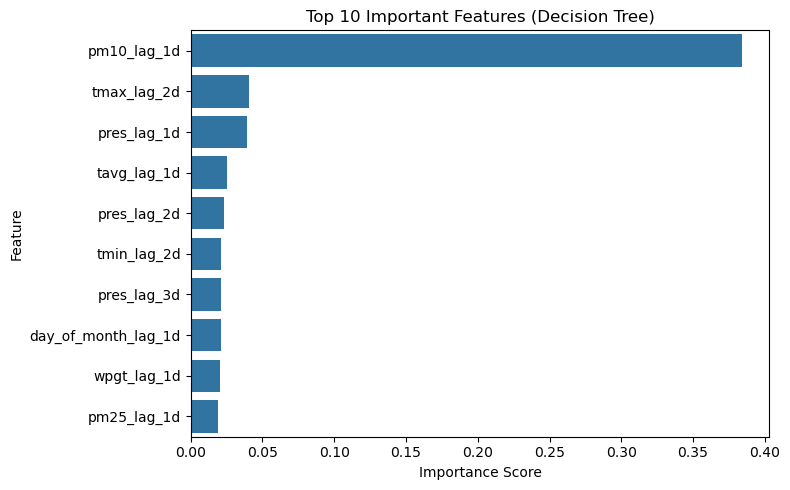

In [47]:
importances = dt_regressor.feature_importances_
# feature_names = X_train.columns

# Get top 10 features
indices = np.argsort(importances)[::-1][:10]
top_features = [(feature_names[i], importances[i]) for i in indices]

print("Top 10 important features for Decision Tree:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[score for _, score in top_features], y=[name for name, _ in top_features])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()

### Random Forest

In [48]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_flat_train, y_flat_train)

RandomForestRegressor()

In [49]:
y_pred = rf_regressor.predict(X_flat_test)

In [50]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 5.8245
  MSE: 79.9344
  RMSE: 8.9406
  R2 Score: 0.5930
--------------------
Metrics for Output 2 (pm10):
  MAE: 3.3155
  MSE: 17.1732
  RMSE: 4.1441
  R2 Score: 0.2967
--------------------
Metrics for Output 3 (no2):
  MAE: 1.5602
  MSE: 3.6983
  RMSE: 1.9231
  R2 Score: 0.0740
--------------------
Metrics for Output 4 (so2):
  MAE: 0.5903
  MSE: 0.6267
  RMSE: 0.7916
  R2 Score: 0.2606
--------------------
Metrics for Output 5 (co):
  MAE: 1.5687
  MSE: 2.6311
  RMSE: 1.6221
  R2 Score: -18.5103
--------------------
Day 2:
Metrics for Output 1 (pm25):
  MAE: 0.5903
  MSE: 0.6267
  RMSE: 0.7916
  R2 Score: 0.2606
--------------------
Metrics for Output 2 (pm10):
  MAE: 1.5687
  MSE: 2.6311
  RMSE: 1.6221
  R2 Score: -18.5103
--------------------
Metrics for Output 3 (no2):
  MAE: 9.9222
  MSE: 154.4271
  RMSE: 12.4269
  R2 Score: 0.2126
--------------------
Metrics for Output 4 (so2):
  MAE: 3.8875
  MSE: 25.3186
  RMSE: 5.0318
  R2 Score: -0

Top 10 important features for Random Forest:
pm10_lag_1d: 0.3818
pres_lag_1d: 0.0335
tmax_lag_1d: 0.0283
tavg_lag_1d: 0.0274
no2_lag_1d: 0.0243
tmax_lag_2d: 0.0203
pres_lag_3d: 0.0198
tavg_lag_2d: 0.0183
tmin_lag_1d: 0.0175
tmax_lag_3d: 0.0165


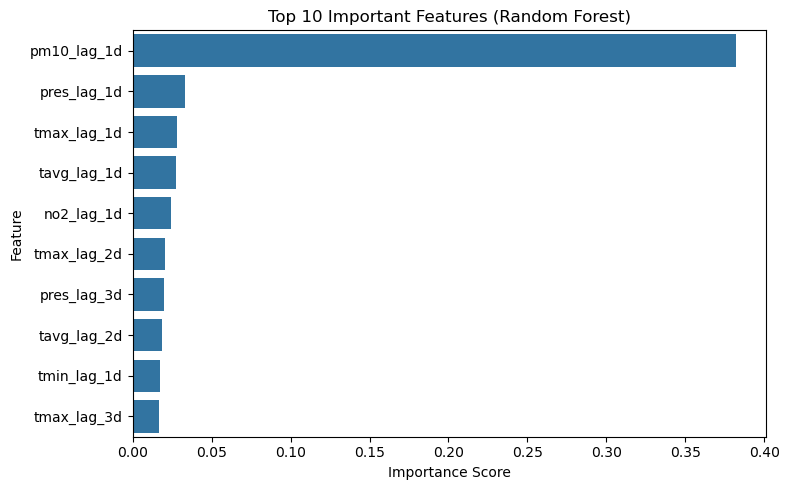

In [51]:
importances = rf_regressor.feature_importances_
# feature_names = X_train.columns

# Get top 10 features
indices = np.argsort(importances)[::-1][:10]
top_features = [(feature_names[i], importances[i]) for i in indices]

print("Top 10 important features for Random Forest:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[score for _, score in top_features], y=[name for name, _ in top_features])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

### XGBoost

In [52]:
base_regressor = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

multi_regressor = MultiOutputRegressor(base_regressor)
multi_regressor.fit(X_flat_train, y_flat_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None, ...))

In [53]:
y_pred = multi_regressor.predict(X_flat_test)

In [54]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 5.0693
  MSE: 63.2097
  RMSE: 7.9505
  R2 Score: 0.6781
--------------------
Metrics for Output 2 (pm10):
  MAE: 3.2582
  MSE: 17.2848
  RMSE: 4.1575
  R2 Score: 0.2922
--------------------
Metrics for Output 3 (no2):
  MAE: 1.3408
  MSE: 2.8116
  RMSE: 1.6768
  R2 Score: 0.2960
--------------------
Metrics for Output 4 (so2):
  MAE: 0.4569
  MSE: 0.3931
  RMSE: 0.6270
  R2 Score: 0.5362
--------------------
Metrics for Output 5 (co):
  MAE: 0.8748
  MSE: 0.8922
  RMSE: 0.9446
  R2 Score: -5.6162
--------------------
Day 2:
Metrics for Output 1 (pm25):
  MAE: 0.4569
  MSE: 0.3931
  RMSE: 0.6270
  R2 Score: 0.5362
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.8748
  MSE: 0.8922
  RMSE: 0.9446
  R2 Score: -5.6162
--------------------
Metrics for Output 3 (no2):
  MAE: 9.8787
  MSE: 152.7909
  RMSE: 12.3609
  R2 Score: 0.2210
--------------------
Metrics for Output 4 (so2):
  MAE: 4.1335
  MSE: 26.4668
  RMSE: 5.1446
  R2 Score: -0.0

In [55]:
# Extract feature importance from each target model
importance_df = pd.DataFrame()

for i, target_name in enumerate(target_columns):  # Replace with your target names
    estimator = multi_regressor.estimators_[i]
    importance_df[target_name] = estimator.feature_importances_

# Set feature names as index
importance_df.index = feature_names  # Set index to feature names

# Display top features for each target
for target in importance_df.columns:
    print(f"\n{target} - Top 10 Features:")
    target_imp = importance_df[target].sort_values(ascending=False).head(10)
    for i, (feat, score) in enumerate(target_imp.items()):
        print(f"{i+1:2d}. {feat:<20} : {score:.4f}")

# Overall top features (averaged across all targets)
overall_top = importance_df.mean(axis=1).sort_values(ascending=False).head(10)
print(f"\nOverall Top 10 Features:")
for i, (feat, score) in enumerate(overall_top.items()):
    print(f"{i+1:2d}. {feat:<20} : {score:.4f}")


pm25 - Top 10 Features:
 1. pm10_lag_1d          : 0.2925
 2. pm25_lag_1d          : 0.2169
 3. no2_lag_1d           : 0.0714
 4. tmax_lag_1d          : 0.0263
 5. month_lag_1d         : 0.0245
 6. month_lag_2d         : 0.0237
 7. pres_lag_1d          : 0.0190
 8. day_of_year_lag_1d   : 0.0158
 9. tmax_lag_2d          : 0.0148
10. pm10_lag_2d          : 0.0144

pm10 - Top 10 Features:
 1. pm10_lag_1d          : 0.1402
 2. no2_lag_1d           : 0.0449
 3. pm10_lag_2d          : 0.0417
 4. pm25_lag_1d          : 0.0306
 5. pres_lag_1d          : 0.0293
 6. is_working_day_lag_2d : 0.0275
 7. pm25_lag_2d          : 0.0255
 8. day_of_year_lag_1d   : 0.0245
 9. day_of_week_lag_3d   : 0.0232
10. no2_lag_2d           : 0.0222

no2 - Top 10 Features:
 1. no2_lag_1d           : 0.1859
 2. tavg_lag_1d          : 0.0925
 3. week_of_year_lag_2d  : 0.0588
 4. tmin_lag_1d          : 0.0403
 5. day_of_year_lag_1d   : 0.0315
 6. day_of_year_lag_2d   : 0.0275
 7. tavg_lag_2d          : 0.0260
 8. tmi

## Real world prediction

In [57]:
# Take last {historical_window_size} items for {prediction_window_size} predictions 
X = merged_df[-historical_window_size:]
X[numerical_features] = scaler.transform(X[numerical_features])
# Input expects multiple windows
X_flat = flatten_windows([X])

y_pred = multi_regressor.predict(X_flat)

# Split y_pred into 3 arrays, one for each prediction day
y_pred_split = np.split(y_pred.flatten(), prediction_window_size)

# Create DataFrame for predictions, each row is a prediction day
predictions_df = pd.DataFrame(y_pred_split, columns=target_columns)

# Definition of Air Quality Index is maximum value of Individual Air Quality Indexes
predictions_df["aqi"] = predictions_df.max(axis=1)

# Set the index to continue from the last date in merged_df
last_date = merged_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_window_size, freq="D")
predictions_df.index = future_dates
print(predictions_df)

                 pm25       pm10       no2       so2        co        aqi
2025-07-22  21.951572  25.875675  5.084496  4.632439  3.044672  25.875675
2025-07-23  42.793774  20.739882  6.640409  3.648938  3.249752  42.793774
2025-07-24  47.704803  15.876596  7.067747  2.884761  3.889493  47.704803


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
